In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import pickle
import os
import pandas as pd
import numpy as np
import json
import re
import shutil
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



In [2]:
DATA_DIR = os.path.join(os.getcwd(),"dataset","News Classification DataSet.json")
MODEL_PATH = os.path.join(os.getcwd(),"model")


In [3]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)

In [4]:
data = []

for line in open(os.path.join(os.getcwd(),"dataset","News Classification DataSet.json"),"r"):
    data.append(json.loads(line))

content, label = [], []
for each in data:
    content.append(each['content'])
    label.append(each['annotation']['label'][0])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']
df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


In [5]:
stopwords_english = set(stopwords.words('english'))
df['content'] = df.content.apply(lambda x:str(x))
def remove_stopwords(s):
    return ' '.join(word for word in s.split() if word not in stopwords_english)
df['content'] = df.content.apply(lambda x:remove_stopwords(x))
df.loc[:,'content']  = df.content.apply(lambda x:" ".join(re.findall('[\w]+',x)))

In [6]:
df.groupby('label').size()

label
Business    1900
SciTech     1900
Sports      1900
World       1900
dtype: int64

In [7]:
texts = df['content'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label'].values #target

print (X.shape)
print(y.shape)

(7600, 24463)
(7600,)


In [8]:
lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X.shape

(7600, 100)

In [9]:
labels_list = list(set(df['label'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)

{'Business': 0, 'World': 1, 'Sports': 2, 'SciTech': 3}


In [10]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(n_estimators=100,random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB()}

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)


In [11]:
def print_confusion_matrix(confusion_matrix, class_names,filename, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(filename)
    fig.savefig(os.path.join(MODEL_PATH,filename+".png"))
    return fig

In [12]:
def print_heatmap(n_labels, n_predictions, class_names,filename):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    matrix = confusion_matrix(n_labels,n_predictions)
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names,filename,figsize=(18,10), fontsize=20)

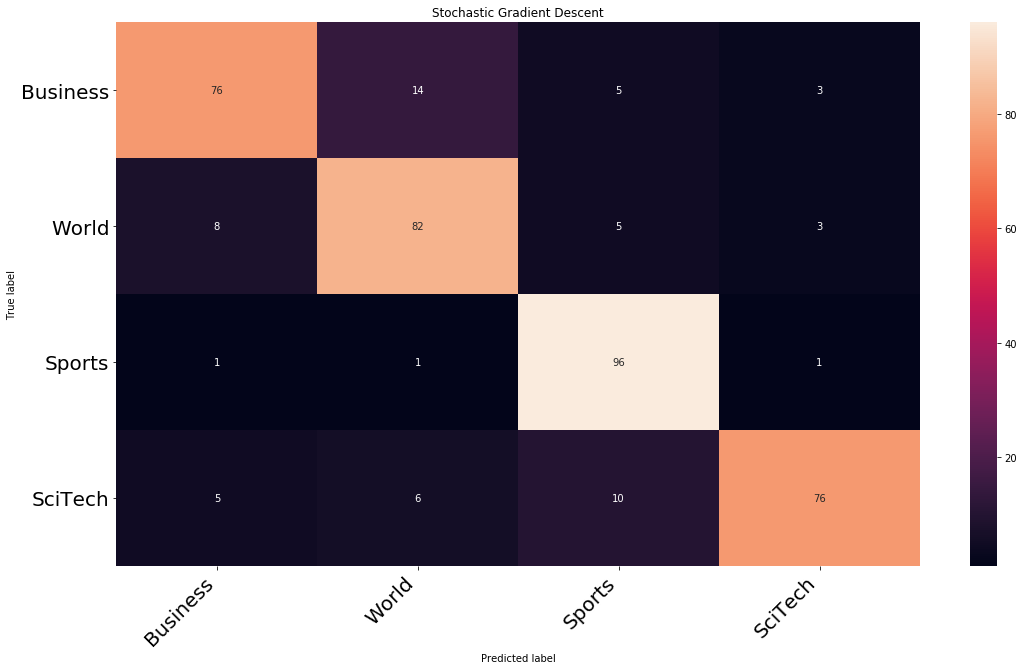

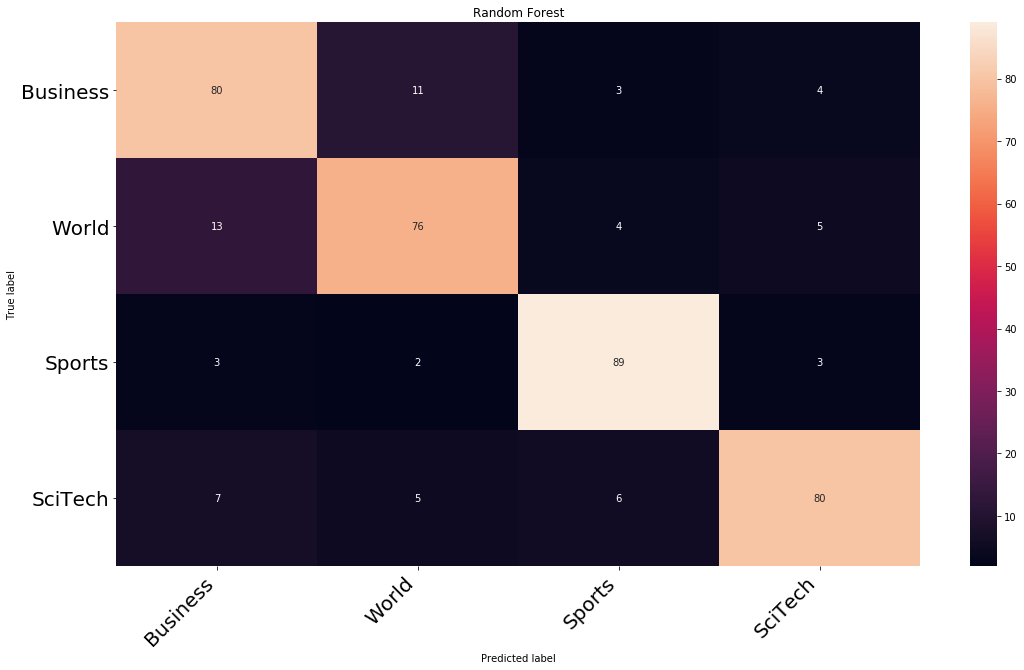

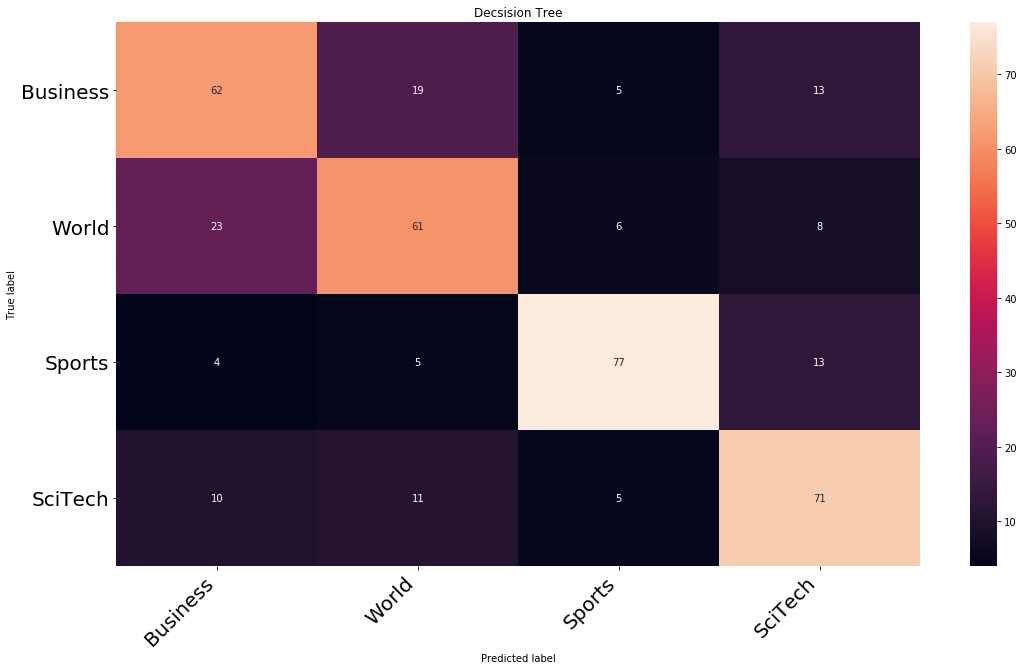

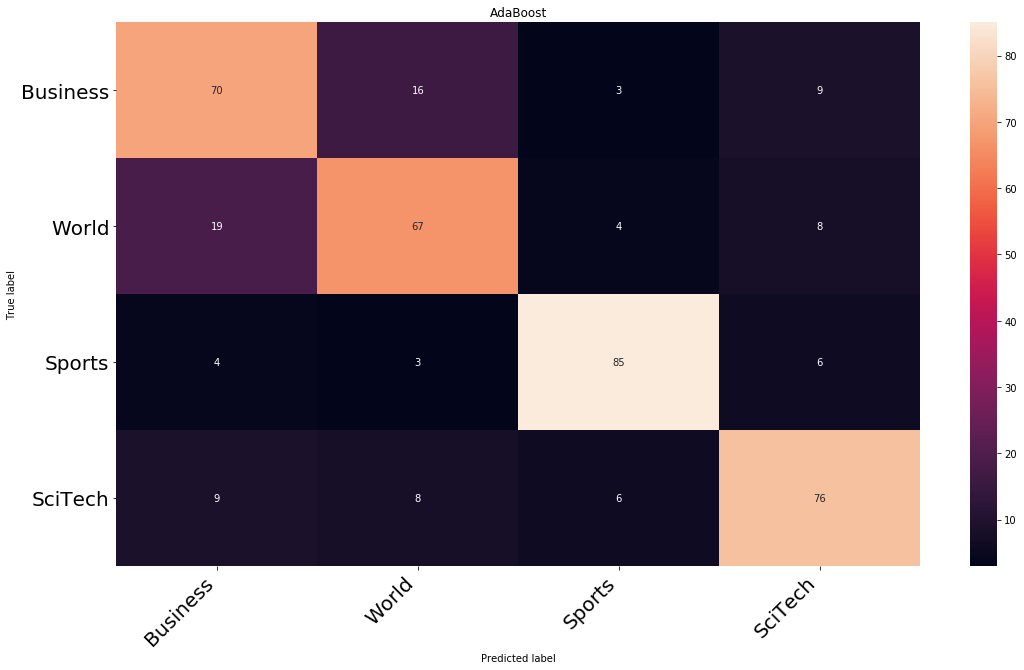

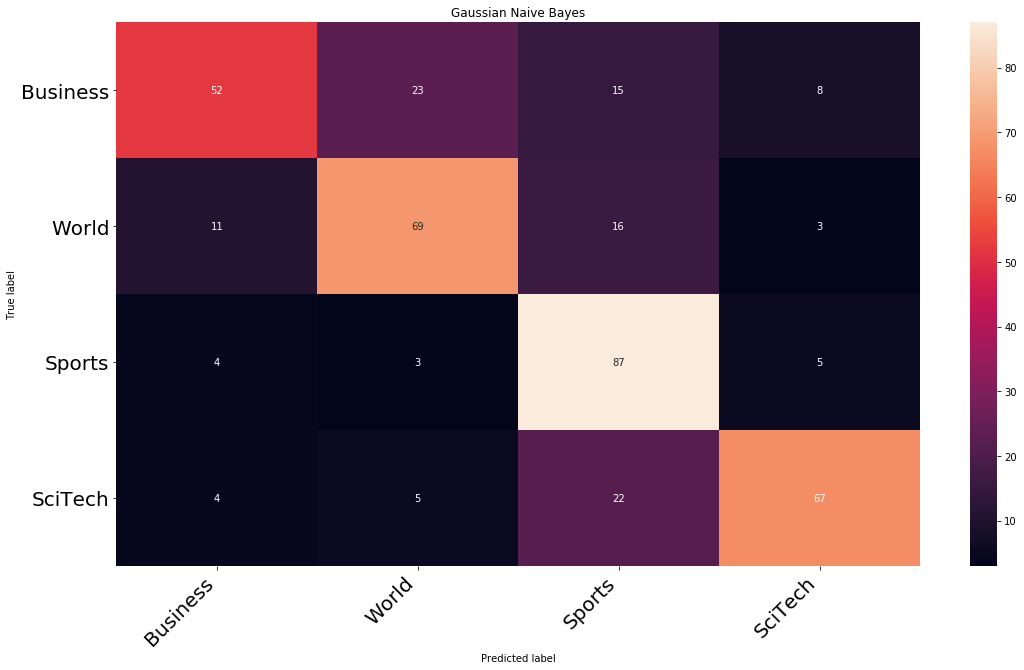

In [13]:

#Function to get the scores for each model in a df
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        pickle.dump(v, open(os.path.join(MODEL_PATH,k)+".pkl", 'wb'))
#         print(y_test.shape)
        y_pred = v.predict(X_test)
#         print(y_pred.shape)

        print_heatmap(y_test,y_pred,class_names,k)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
        model_comparison_df.to_csv(os.path.join(os.getcwd(),"csv_files","model_results.csv"),index=False)


model_score_df(model_dict)

In [14]:
results = pd.read_csv(os.path.join(os.getcwd(),"csv_files","model_results.csv"))
results.head()

,model_name,accuracy_score,precision_score,recall_score,f1_score
0,Stochastic Gradient Descent,0.830702,0.834292,0.830702,0.829344
1,Random Forest,0.815789,0.816100,0.815789,0.815498
2,AdaBoost,0.749561,0.750244,0.749561,0.749697
3,Gaussian Naive Bayes,0.690789,0.705608,0.690789,0.687308
4,Decsision Tree,0.680702,0.682522,0.680702,0.681222
